In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KernelDensity
import rasterio
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt
import os

In [6]:
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code")

In [4]:


def create_poi_kde_with_residential_mask(
    pois_gdf,
    city_boundary_gdf,
    residential_path="data/raw/ghsl_residential_100m_utm43n.tif",
    output_path="data/output/poi_kde_residential_masked.tif",
    bandwidth=1600,
    pixel_size=100,
    categories=['sustenance', 'facilities', 'healthcare']
):
    """
    Create POI kernel density estimation for specific categories and mask by residential areas.

    Parameters:
    -----------
    pois_gdf : GeoDataFrame
        POI points with category information
    city_boundary_gdf : GeoDataFrame
        Polygon boundary of Jaipur city
    residential_path : str
        Path to residential building footprint raster
    output_path : str
        Path for output KDE tiff file
    bandwidth : int
        KDE bandwidth in meters
    pixel_size : int
        Output resolution in meters
    categories : list
        POI categories to include in analysis
    """
    print(f"Creating KDE for {', '.join(categories)} with {bandwidth}m bandwidth")

    # Ensure consistent CRS (UTM Zone 43N)
    target_crs = "EPSG:32643"
    if pois_gdf.crs != target_crs:
        pois_gdf = pois_gdf.to_crs(target_crs)
    if city_boundary_gdf.crs != target_crs:
        city_boundary_gdf = city_boundary_gdf.to_crs(target_crs)

    # Filter POIs by selected categories
    filtered_pois = pois_gdf[pois_gdf['poi_category'].isin(categories)]
    print(f"Selected {len(filtered_pois)} POIs from {len(categories)} categories")

    # Get city boundary for analysis extent
    city_polygon = city_boundary_gdf.unary_union

    # Add buffer to avoid edge effects in KDE
    buffer_distance = 1000  # 1km buffer
    buffered_boundary = city_polygon.buffer(buffer_distance)
    minx, miny, maxx, maxy = buffered_boundary.bounds

    # Create analysis grid
    width = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))
    transform = from_bounds(minx, miny, maxx, maxy, width, height)

    print(f"Analysis grid: {width}x{height} pixels at {pixel_size}m resolution")

    # Create coordinate arrays for analysis grid
    x_coords = np.arange(width) * pixel_size + minx + pixel_size/2
    y_coords = np.arange(height) * pixel_size + miny + pixel_size/2
    X, Y = np.meshgrid(x_coords, y_coords[::-1])  # Reverse y for raster orientation
    grid_coords = np.column_stack([X.flatten(), Y.flatten()])

    # Extract POI coordinates for KDE
    poi_coords = np.column_stack([
        filtered_pois.geometry.x.values,
        filtered_pois.geometry.y.values
    ])

    # Perform kernel density estimation
    print(f"Performing KDE with {bandwidth}m bandwidth...")
    kde = KernelDensity(bandwidth=bandwidth, metric='euclidean', kernel='gaussian')
    kde.fit(poi_coords)

    # Evaluate KDE at all grid points
    log_density = kde.score_samples(grid_coords)
    density = np.exp(log_density)
    kde_raster = density.reshape(height, width)

    # Load residential mask
    print(f"Loading residential mask from: {residential_path}")
    with rasterio.open(residential_path) as src:
        residential_data = src.read(1)
        residential_transform = src.transform
        residential_bounds = src.bounds
        residential_shape = (src.height, src.width)

    # Create residential mask aligned with analysis grid
    print("Creating residential mask for analysis grid...")
    residential_mask = np.zeros((height, width), dtype=bool)

    # Sample residential raster at analysis grid points
    for i in range(height):
        for j in range(width):
            x, y = x_coords[j], y_coords[height-1-i]  # Raster y is flipped

            # Convert to residential raster coordinates
            col = int((x - residential_bounds[0]) / abs(residential_transform[0]))
            row = int((residential_bounds[3] - y) / abs(residential_transform[4]))

            # Set True for places where GHSL has values (>0), to mark as residential area.
            if (0 <= row < residential_shape[0] and 0 <= col < residential_shape[1]):
                residential_mask[i, j] = residential_data[row, col] > 0

    # Apply residential mask - only keep values where residential mask is True
    print("Applying residential mask to KDE...")
    masked_kde = kde_raster.copy()
    masked_kde[~residential_mask] = 0  # Set non-residential areas to 0

    # Create output directory if needed
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Export to GeoTIFF
    print(f"Exporting result to: {output_path}")
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype='float32',
        crs=target_crs,
        transform=transform,
        nodata=0,
        compress='lzw'
    ) as dst:
        dst.write(masked_kde.astype('float32'), 1)

        # Add metadata
        dst.update_tags(
            description=f"POI KDE for {', '.join(categories)}",
            bandwidth=str(bandwidth),
            pixel_size=str(pixel_size),
            masked="residential areas only (GHSL > 0)"
        )

    print("KDE creation and export completed successfully")
    return masked_kde, transform

# Example usage:
# pois_gdf = gpd.read_file("data/cleaned/jaipur_pois_fixed.geojson")
# city_boundary_gdf = gpd.read_file("data/raw/JMC_union.geojson")
#
# kde_result, transform = create_poi_kde_with_residential_mask(
#     pois_gdf,
#     city_boundary_gdf,
#     output_path="data/output/combined_poi_kde_1600m_residential.tif"
# )

In [5]:
pois_gdf = gpd.read_file("data/cleaned/jaipur_pois_fixed.geojson")
city_boundary_gdf = gpd.read_file("data/raw/JMC_union.geojson")

In [8]:
kde_result, transform = create_poi_kde_with_residential_mask(
    pois_gdf,
    city_boundary_gdf,
     output_path="data/cleaned/combined_poi_kde_1600m_residential.tif")


Creating KDE for sustenance, facilities, healthcare with 1600m bandwidth
Selected 1284 POIs from 3 categories
Analysis grid: 243x301 pixels at 100m resolution
Performing KDE with 1600m bandwidth...


C:\Users\Aprilmiaoyilee\AppData\Local\Temp\ipykernel_28944\223639814.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_polygon = city_boundary_gdf.unary_union


Loading residential mask from: data/raw/ghsl_residential_100m_utm43n.tif
Creating residential mask for analysis grid...
Applying residential mask to KDE...
Exporting result to: data/cleaned/combined_poi_kde_1600m_residential.tif
KDE creation and export completed successfully


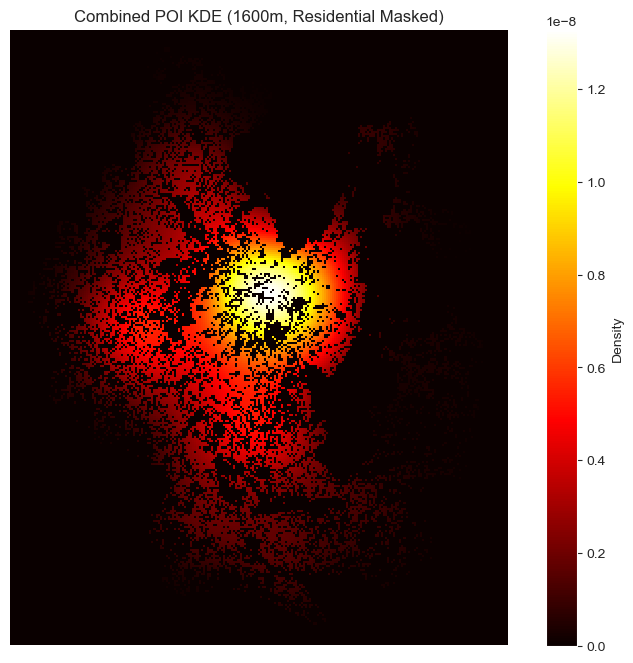

In [9]:
import rasterio
import matplotlib.pyplot as plt

# Load the raster file
with rasterio.open('data/cleaned/combined_poi_kde_1600m_residential.tif') as src:
    data = src.read(1)  # Read the first band

# Plot the raster data
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar(label='Density')
plt.title('Combined POI KDE (1600m, Residential Masked)')
plt.axis('off')
plt.show()

In [8]:


with rasterio.open('data/cleaned/combined_poi_kde_1600m_residential.tif') as src:
    # Read the first band data
    band_data = src.read(1)

    # Calculate value range
    min_value = np.min(band_data)
    max_value = np.max(band_data)
print(f"Value range of the first band: Min = {min_value}, Max = {max_value}")


Value range of the first band: Min = 0.0, Max = 1.3284827460324777e-08
